### This script makes domain and surface files for the tropical part of the Americas, Africa and Asia

In [20]:
from scipy.stats import qmc
import numpy as np

import csv
import xarray as xr
import rioxarray as rx
import pandas as pd
import os
import netCDF4 as nc4
import sys
import shutil
from tempfile import TemporaryFile                                                                                                                                 
import argparse                                                                                                                                                                                                                                                                                                       
import tempfile 
import random
import re

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
from matplotlib.colors import BoundaryNorm
import cartopy.crs as ccrs

from cartopy.io.shapereader import Reader
import shapefile
from shapely.geometry import shape, Point, LinearRing

import regionmask

from shapely.geometry import MultiPolygon, Polygon

### Load the domain file that we are slicing into separate tropical continent domain files

In [21]:
domain = '/global/homes/j/jneedham/tropical-fixed-biog/domainsurf/domain.lnd.fv4x5_gx3v7.091218.nc'
domain = xr.open_dataset(domain, decode_times=False)

In [22]:
domain.xc[0,:]

<xarray.DataArray 'xc' (ni: 72)>
array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,  55.,
        60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105., 110., 115.,
       120., 125., 130., 135., 140., 145., 150., 155., 160., 165., 170., 175.,
       180., 185., 190., 195., 200., 205., 210., 215., 220., 225., 230., 235.,
       240., 245., 250., 255., 260., 265., 270., 275., 280., 285., 290., 295.,
       300., 305., 310., 315., 320., 325., 330., 335., 340., 345., 350., 355.])
Coordinates:
    xc       (ni) float64 ...
    yc       (ni) float64 ...
Dimensions without coordinates: ni
Attributes:
    long_name:  longitude of grid cell center
    units:      degrees_east
    bounds:     xv

#### Crop to just the  tropics

In [23]:
cropped_domain = domain.sel(nj=slice(15,31))

#### Seperate domains for each continent

In [24]:
domain_americas = cropped_domain.isel(ni=slice(37,69))
domain_asia = cropped_domain.isel(ni=slice(13,37))

In [25]:
domain_americas.xc[0,:]

<xarray.DataArray 'xc' (ni: 32)>
array([185., 190., 195., 200., 205., 210., 215., 220., 225., 230., 235., 240.,
       245., 250., 255., 260., 265., 270., 275., 280., 285., 290., 295., 300.,
       305., 310., 315., 320., 325., 330., 335., 340.])
Coordinates:
    xc       (ni) float64 ...
    yc       (ni) float64 ...
Dimensions without coordinates: ni
Attributes:
    long_name:  longitude of grid cell center
    units:      degrees_east
    bounds:     xv

In [26]:
domain_asia.xc[0,:]

<xarray.DataArray 'xc' (ni: 24)>
array([ 65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105., 110., 115., 120.,
       125., 130., 135., 140., 145., 150., 155., 160., 165., 170., 175., 180.])
Coordinates:
    xc       (ni) float64 ...
    yc       (ni) float64 ...
Dimensions without coordinates: ni
Attributes:
    long_name:  longitude of grid cell center
    units:      degrees_east
    bounds:     xv

#### Convert longitude to -180 to 180 so Africa domain is continuous

In [27]:
#cropped_domain = cropped_domain.assign_coords(xc=(((cropped_domain.xc + 180) % 360) - 180))
#cropped_domain = cropped_domain.assign_coords(xv=(((cropped_domain.xv + 180) % 360) - 180))

In [28]:
df1 = cropped_domain.isel(ni=slice(69,72))
df2 = cropped_domain.isel(ni=slice(0,13))
domain_africa = xr.concat([df1,df2],dim='ni')


In [29]:
# save the new file 
domain_africa.to_netcdf('/global/homes/j/jneedham/tropical-fixed-biog/domainsurf/africa_domain.nc')
domain_americas.to_netcdf('/global/homes/j/jneedham/tropical-fixed-biog/domainsurf/americas_domain.nc')
domain_asia.to_netcdf('/global/homes/j/jneedham/tropical-fixed-biog/domainsurf/asia_domain.nc')

### Load a FATES run to extract coordinates 
#### used for plotting

In [30]:
fates = '/pscratch/sd/j/jneedham/elm_runs/fbnc_cal/apr24/fbnc_f45_v3_rdark_vert_1.E5e483733fa-F77ac7623.2024-04-24/run/fbnc_f45_v3_rdark_vert_1.E5e483733fa-F77ac7623.2024-04-24.2190s.nc'
fates = xr.open_dataset(fates, decode_times=False)

In [31]:
cropped_fates = fates.isel(lat=slice(15,31))

fates_am = cropped_fates.isel(lon=slice(37,69))
fates_as = cropped_fates.isel(lon=slice(13,37))
#fates_af = cropped_fates.isel(lon=slice(0,13))

In [32]:
# extract lat and lon coords
fates_lon_americas = fates_am.coords['lon']
fates_lat_americas = fates_am.coords['lat']

#fates_lon_africa = fates_af.coords['lon']
#fates_lat_africa = fates_af.coords['lat']

fates_lon_asia = fates_as.coords['lon']
fates_lat_asia = fates_as.coords['lat']

In [33]:
domain_americas = domain_americas.rename({'nj': 'lat', 'ni':'lon'})
area_americas = domain_americas.area
area_americas = area_americas.assign_coords({'lon':fates_lon_americas})
area_americas = area_americas.assign_coords({'lat':fates_lat_americas})


In [34]:
# domain_africa = domain_africa.rename({'nj': 'lat', 'ni':'lon'})
# area_africa = domain_africa.area
# area_africa = area_africa.assign_coords({'lon':fates_lon_africa})
# area_africa = area_africa.assign_coords({'lat':fates_lat_africa})


In [35]:
domain_asia = domain_asia.rename({'nj': 'lat', 'ni':'lon'})
area_asia = domain_asia.area
area_asia = area_asia.assign_coords({'lon':fates_lon_asia})
area_asia = area_asia.assign_coords({'lat':fates_lat_asia})


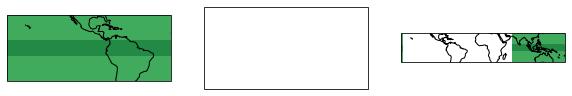

In [36]:
fig, (axs1,axs2,axs3) = plt.subplots(nrows=1,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(10,4))

clevs=np.arange(0,0.01,0.001)
cs = area_americas.plot(levels=clevs,cmap='Greens', ax=axs1, label='Area', add_colorbar=False)
axs1.coastlines()

#cs = area_africa.plot(levels=clevs,cmap='Greens', ax=axs2, label='Area', add_colorbar=False)
#axs2.coastlines()

cs = area_asia.plot(levels=clevs,cmap='Greens', ax=axs3, label='Area', add_colorbar=False)
axs3.coastlines()

### Surface data file

In [37]:
surf = '/global/homes/j/jneedham/tropical-fixed-biog/domainsurf/surfdata_4x5_simyr2000_c130927.nc'
surf = xr.open_dataset(surf, decode_times=False)

In [38]:
cropped_surf = surf.sel(lsmlat=slice(15,31))

In [39]:
surf_americas = cropped_surf.isel(lsmlon=slice(37,69))
surf_asia = cropped_surf.isel(lsmlon=slice(13,37))

df1 = cropped_surf.isel(lsmlon=slice(69,72))
df2 = cropped_surf.isel(lsmlon=slice(0,13))
surf_africa = xr.concat([df1,df2],dim='lsmlon')

In [40]:
# save the new file 
surf_americas.to_netcdf('/global/homes/j/jneedham/tropical-fixed-biog/domainsurf/americas_surf.nc')
surf_asia.to_netcdf('/global/homes/j/jneedham/tropical-fixed-biog/domainsurf/asia_surf.nc')
surf_africa.to_netcdf('/global/homes/j/jneedham/tropical-fixed-biog/domainsurf/africa_surf.nc')